In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import json

from matplotlib import font_manager

# import nodes-values-relation tags

In [2]:
JSON_folder = "../data/json_data/ncn_japan/"

with open(JSON_folder + 'nodes.json') as f:
    data = json.load(f)

# Normalize the JSON structure
df_nodes = pd.json_normalize(data)

with open(JSON_folder + 'ways.json') as f:
    data = json.load(f)
df_ways = pd.json_normalize(data)

with open(JSON_folder + 'relations.json') as f:
    data = json.load(f)
df_relation = pd.json_normalize(data)

# Extract the id, lat, lon, and expand the tags dictionary
#df_expanded = pd.json_normalize(data, 'tags', ['id', 'lat', 'lon'], sep='_')

In [3]:
df_nodes.columns = df_nodes.columns.str.replace('tags.', '', regex=False)
df_nodes = df_nodes.drop(columns=[col for col in df_nodes.columns if 'name' in col])

df_ways.columns = df_ways.columns.str.replace('tags.', '', regex=False)
df_ways = df_ways.drop(columns=[col for col in df_ways.columns if 'name' in col])

df_relation.columns = df_relation.columns.str.replace('tags.', '', regex=False)
df_relation = df_relation.drop(columns=[col for col in df_relation.columns if 'name' in col])

# Tags NAN frequency

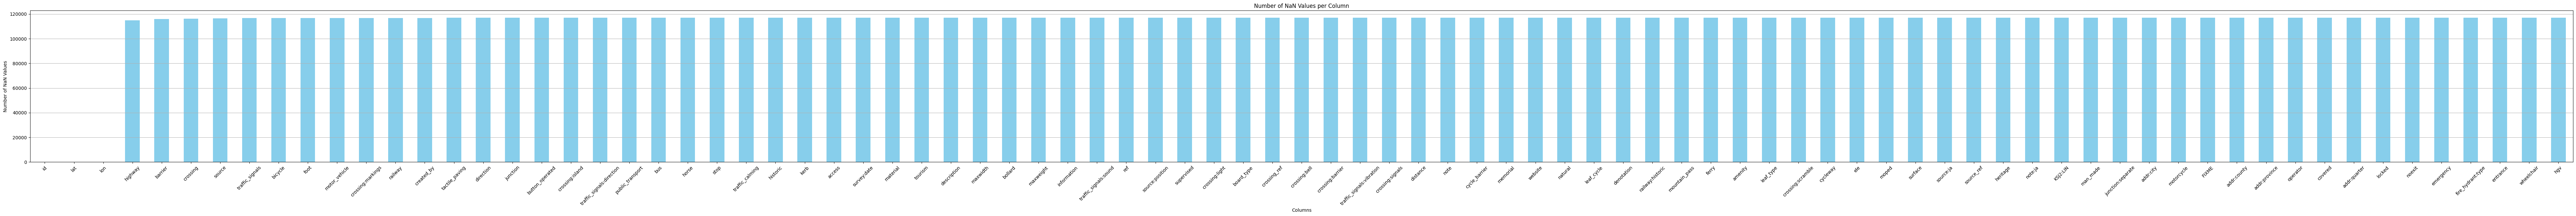

In [4]:
nan_count_nodes = df_nodes.isna().sum().sort_values()

plt.figure(figsize=(100, 6))
nan_count_nodes[0:100].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

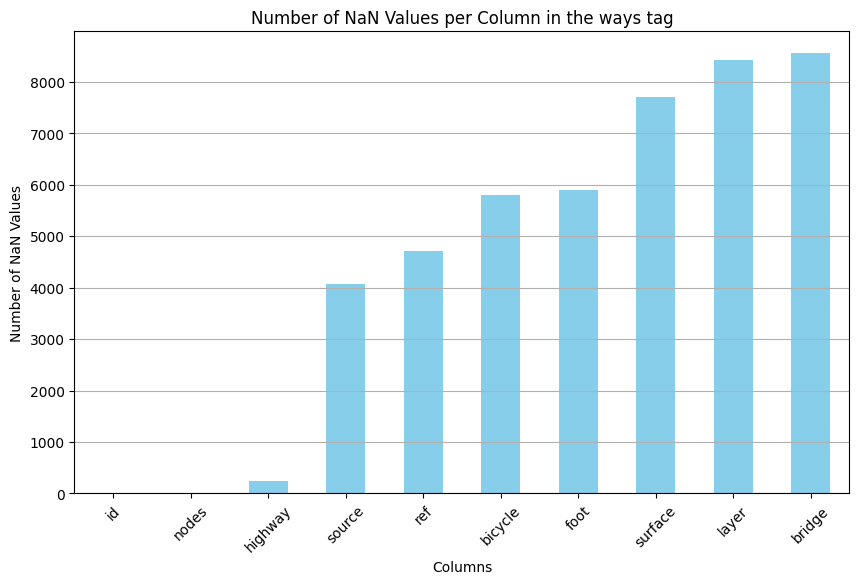

In [5]:
nan_count_ways = df_ways.isna().sum().sort_values()

plt.figure(figsize=(10, 6))
nan_count_ways[0:10].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column in the ways tag')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

#plt.savefig('Image/Nan_values_ways.png')

# Tags NAN frequency, for a specific tag=value

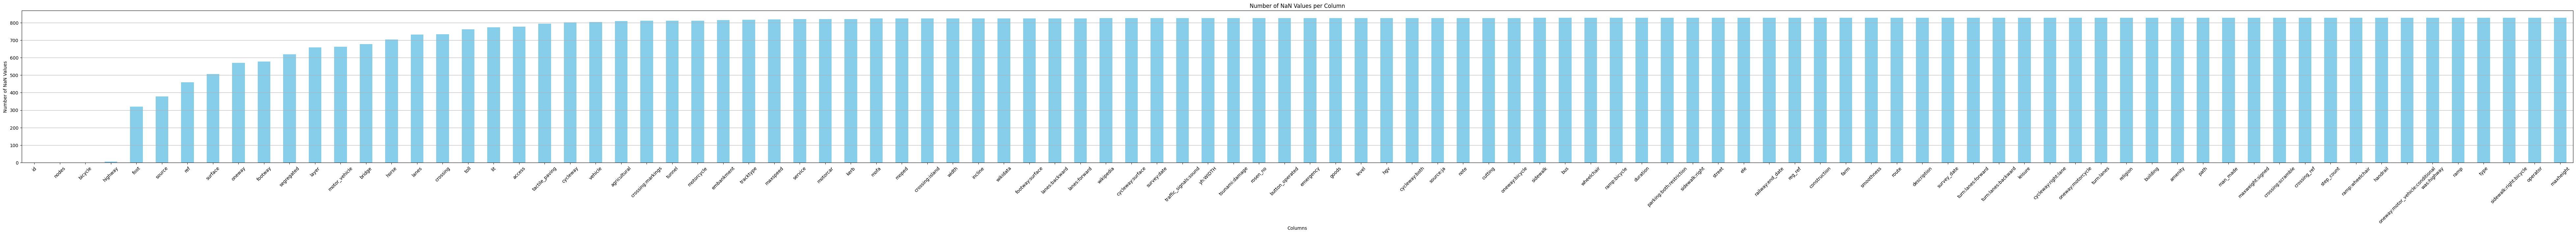

In [6]:
bicycle_tags = df_ways[df_ways["bicycle"] == "yes"]
bicycle_count = bicycle_tags.isna().sum().sort_values()

plt.figure(figsize=(100, 6))
bicycle_count[0:100].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Tags Frequency in NCN compare to frequency in all japan

## Ways

### Select important tags

In [7]:
tags_list = df_ways.columns[2:]

tag_ways = {}
for tag in tags_list:
    values = df_ways[tag].dropna().unique().tolist()
    if len(values) < 20 :
        tag_ways[tag] = values

### Extract global osm statistics for each of our tags

In [8]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None

stat_ways_global = {}

bool_load = False

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_ways.keys())
    for key, values in tag_ways.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic_ways = {}
        for value in values:
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic_ways[value] = stats['data'][2]['count_fraction']
            else :
                print("no stat for ", value)
        stat_ways_global[key] = dic_ways

        with open(JSON_folder + 'stat_ways.json', 'w') as json_file:
            json.dump(stat_ways_global, json_file)

else :
    with open(JSON_folder + 'stat_ways.json', 'r') as json_file:
        stat_ways_global = json.load(json_file)



### Compare frequency

In [9]:
#n_total_node = 240_455_144

stat_ways_ncn = {}
df_ways_cut = df_ways[tag_ways.keys()]

for col in df_ways_cut.columns:
    dic_ways = {}
    for value, count in df_ways_cut[col].dropna().value_counts().items():
        dic_ways[value] = count/df_ways.shape[0]
    stat_ways_ncn[col] = dic_ways

In [10]:
df_stat_ways = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_ways_ncn.keys():
    for value in stat_ways_ncn[tag].keys():
        stat_ncn = stat_ways_ncn[tag][value]
        stat_all = stat_ways_global[tag][value]
        df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]

/tmp/ipykernel_7039/2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_7039/2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
/tmp/ipykernel_7039/2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [11]:
df_stat_ways = df_stat_ways.loc[:,df_stat_ways.loc["stat global"] > 0.0001]
df_stat_ways.loc["relative error"] = (df_stat_ways.loc["stat ncn"] - df_stat_ways.loc["stat global"])/df_stat_ways.loc["stat global"]
sort_ways = df_stat_ways.T["relative error"].sort_values(ascending=False)

Text(0.5, 1.0, 'Frequency')

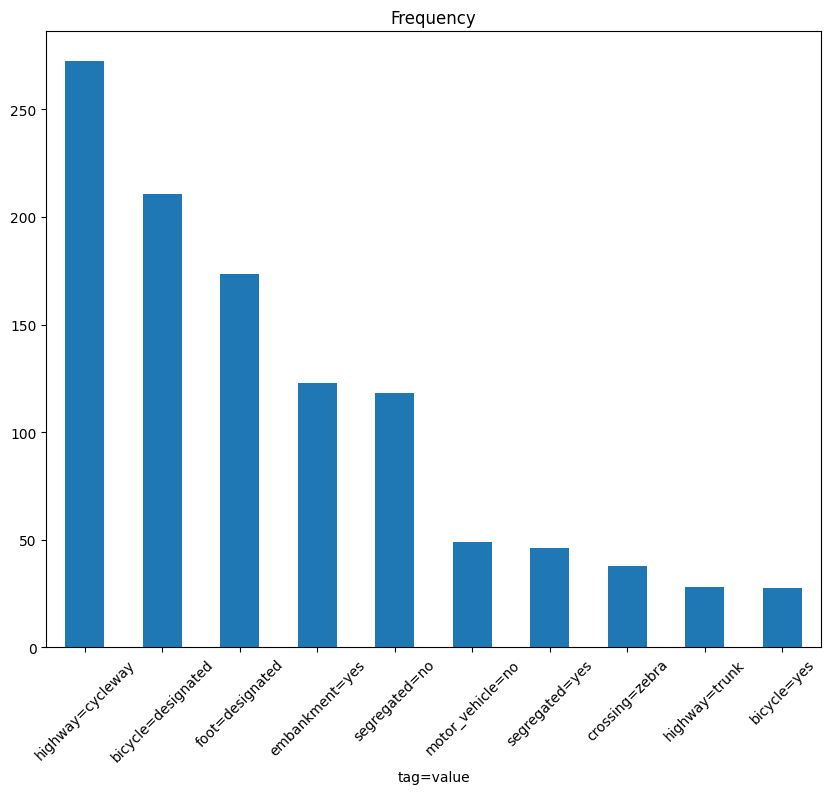

In [12]:
sort_ways[sort_ways > 10].iloc[:10].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

#plt.savefig('Image/Selected_tags.png')

Text(0.5, 1.0, 'Frequency')

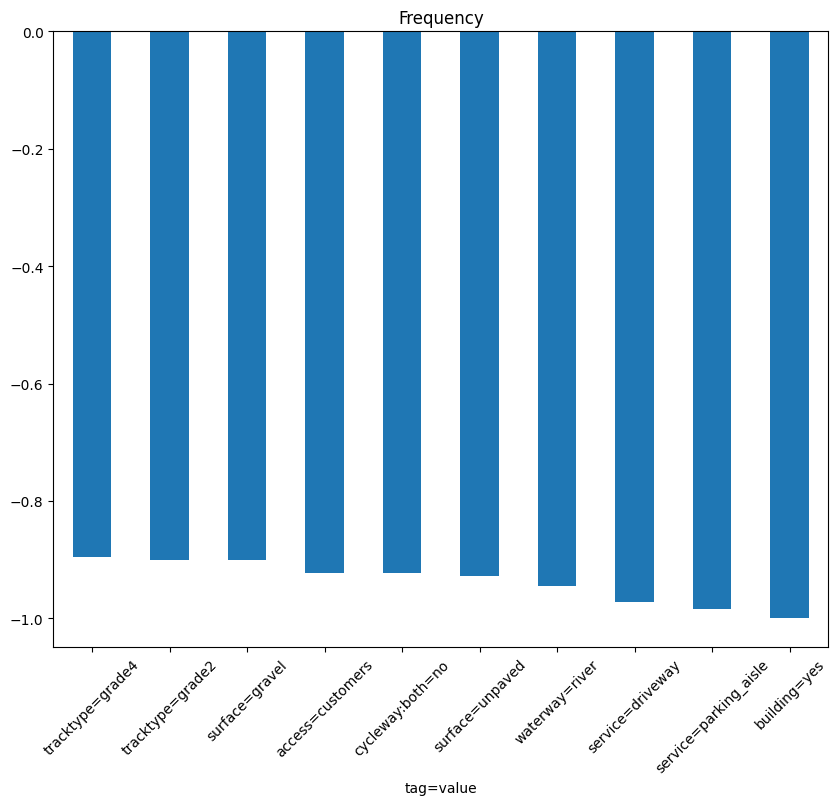

In [13]:
sort_ways.iloc[-10:].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

#plt.savefig('Image/Negative_freq_tags.png')

In [14]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None



stat_nodes_global = {}

bool_load = False

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_nodes.keys())
    for key, values in tag_nodes.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic_node = {}
        for value in values:
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic_node[value] = stats['data'][1]['count_fraction']

        stat_nodes_global[key] = dic_node

        with open(JSON_folder + 'stat_nodes.json', 'w') as json_file:
            json.dump(stat_nodes_global, json_file)
else :
    with open(JSON_folder + 'stat_nodes.json', 'r') as json_file:
        stat_nodes_global = json.load(json_file)



In [15]:
#n_total_node = 240_455_144

stat_nodes_ncn = {}
df_cut = df_nodes[tag_nodes.keys()]

for col in df_cut.columns:
    dic = {}
    for value, count in df_cut[col].dropna().value_counts().items():
        dic[value] = count/df_nodes.shape[0] 
    stat_nodes_ncn[col] = dic

NameError: name 'tag_nodes' is not defined

In [16]:
df_stat_nodes = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_nodes_ncn.keys():
    for value in stat_nodes_ncn[tag].keys():
        stat_ncn = stat_nodes_ncn[tag][value]
        stat_all = stat_nodes_global[tag][value]
        df_stat_nodes[tag + "=" + value] = [stat_ncn, stat_all]

In [17]:
df_stat_nodes = df_stat_nodes.loc[:,df_stat_nodes.loc["stat global"] > 0.0001]
df_stat_nodes.loc["relative error"] = (df_stat_nodes.loc["stat ncn"] - df_stat_nodes.loc["stat global"])/df_stat_nodes.loc["stat global"]
sort = df_stat_nodes.T["relative error"].sort_values(ascending=False)

ValueError: cannot set a frame with no defined columns

In [18]:
sort.iloc[:10].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

NameError: name 'sort' is not defined

Text(0.5, 1.0, 'Frequency')

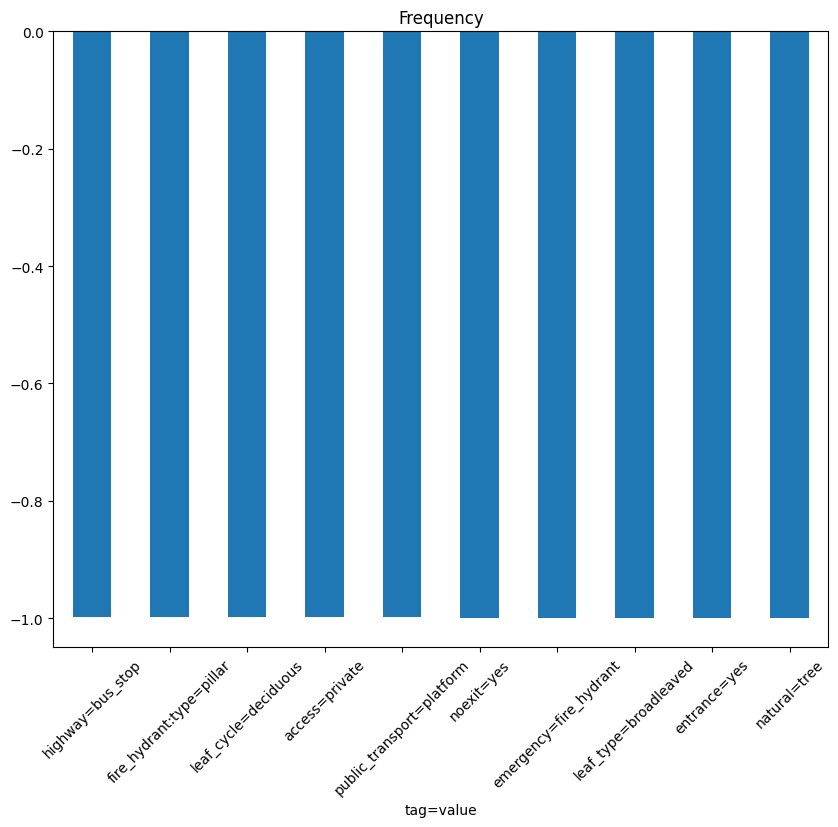

In [ ]:
sort.iloc[-10:].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')


# Scoring

## Extract kansai road with the selected tags
- scoring fonction : somme pondéré par la la présence du tag dans les nationnal road

In [19]:
JSON_folder_2 = "../data/json_data/selected_ways/"
with open(JSON_folder_2 + 'ways.json') as f:
    data = json.load(f)
df_selected_ways = pd.json_normalize(data)

df_selected_ways.columns = df_selected_ways.columns.str.replace('tags.', '', regex=False)
df_selected_ways["score"] = 0.0

#### Histogram of scores for the national roads

In [21]:
import numpy as np

# parcour every important tags, add score for each line.
keys = [string.split("=")[0] for string in sort_ways.index.values]
filtered_keys = [col for col in keys if col in df_selected_ways.columns]
filtered_keys = list(set(filtered_keys))
df_filter = df_selected_ways[filtered_keys]

for kv, freq in sort_ways.items():
    key = kv.split("=")[0]
    value = kv.split("=")[1]
    if key in df_filter.columns:
        df_selected_ways.loc[df_filter[key] == value, "score"] += freq

In [22]:
JSON_folder_2 = "../data/json_data/selected_ways/"
with open(JSON_folder_2 + 'nodes.json') as f:
    data = json.load(f)

# Allowed keys
allowed_keys = {'lat', 'lon', 'id'}

# Filter dictionaries
data = [{k: v for k, v in d.items() if k in allowed_keys} for d in data]

df_nodes_coords = pd.json_normalize(data)
df_nodes_coords["score"] = 0.0
df_nodes_coords["ncn"] = False

In [23]:
df_selected_ways = df_selected_ways.sort_values(by="score", ascending=False)

In [24]:
import numpy as np

JSON_folder_3 = "../data/json_data/ncn_japan/"
with open(JSON_folder_3 + 'ways.json') as f:
    data = json.load(f)

df_ncn_ways = pd.json_normalize(data)

wether_ncn = df_selected_ways['id'].isin(df_ncn_ways['id'])

top_roads = df_selected_ways.iloc[0:2000]
count = 0
for nodes, score, ncn_status in zip(top_roads["nodes"], top_roads["score"], wether_ncn):
    for node in nodes:
        df_nodes_coords.loc[df_nodes_coords["id"]==node, "score"] = score
        df_nodes_coords.loc[df_nodes_coords["id"]==node, "ncn"] = ncn_status
    count += 1
    print(str(count)+"/2000")


1/2000
2/2000
3/2000
4/2000
5/2000
6/2000
7/2000
8/2000
9/2000
10/2000
11/2000
12/2000
13/2000
14/2000
15/2000
16/2000
17/2000
18/2000
19/2000
20/2000
21/2000
22/2000
23/2000
24/2000
25/2000
26/2000
27/2000
28/2000
29/2000
30/2000
31/2000
32/2000
33/2000
34/2000
35/2000
36/2000
37/2000
38/2000
39/2000
40/2000
41/2000
42/2000
43/2000
44/2000
45/2000
46/2000
47/2000
48/2000
49/2000
50/2000
51/2000
52/2000
53/2000
54/2000
55/2000
56/2000
57/2000
58/2000
59/2000
60/2000
61/2000
62/2000
63/2000
64/2000
65/2000
66/2000
67/2000
68/2000
69/2000
70/2000
71/2000
72/2000
73/2000
74/2000
75/2000
76/2000
77/2000
78/2000
79/2000
80/2000
81/2000
82/2000
83/2000
84/2000
85/2000
86/2000
87/2000
88/2000
89/2000
90/2000
91/2000
92/2000
93/2000
94/2000
95/2000
96/2000
97/2000
98/2000
99/2000
100/2000
101/2000
102/2000
103/2000
104/2000
105/2000
106/2000
107/2000
108/2000
109/2000
110/2000
111/2000
112/2000
113/2000
114/2000
115/2000
116/2000
117/2000
118/2000
119/2000
120/2000
121/2000
122/2000
123/2000
1

In [25]:
print(df_nodes_coords[df_nodes_coords["score"] != 0])

                 id        lat         lon      score    ncn
121       241793373  34.597581  135.550205  31.819300  False
1120      252996520  34.647415  135.801592  31.666812  False
1202      252997571  35.065489  135.875967  29.974368  False
1550      253050311  34.902757  135.749222  31.666812  False
1589      253054490  34.763561  135.897092  31.572903  False
...             ...        ...         ...        ...    ...
531200  11810528690  34.720014  135.518914  35.249968   True
531366  11835046592  34.712953  135.522096  44.806888   True
531466  11835046772  34.709150  135.519640  44.806888   True
532194  11885197006  35.024079  135.949840  32.241758  False
532195  11885197007  35.017105  135.967642  33.478407  False

[15124 rows x 5 columns]


In [26]:
df_nodes_coords[df_nodes_coords["score"] != 0].to_json('../data/selected/df_scored_nodes.json', orient='records')
df_nodes_coords = pd.read_json('../data/selected/df_scored_nodes.json', orient='records')

#### Histogram of scores for all the selected ways

/tmp/ipykernel_7039/4161550813.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


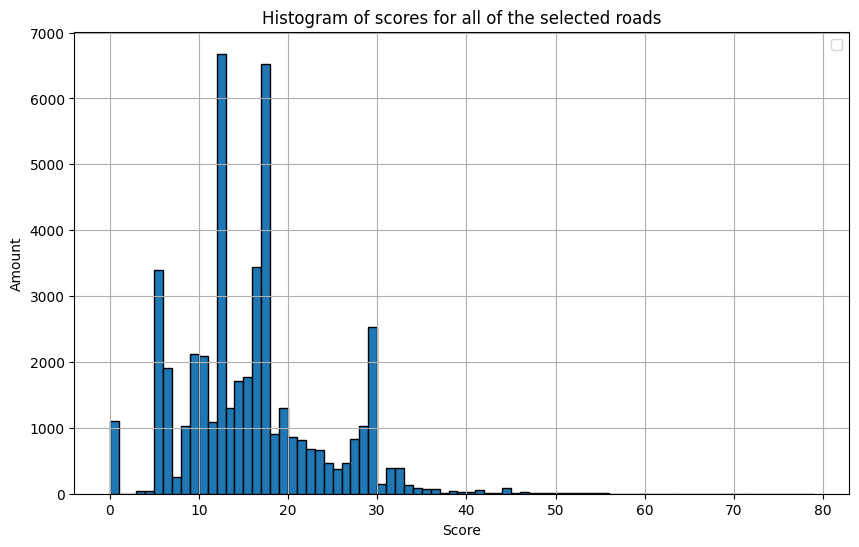

In [28]:
# Define the bin edges
max_score = int(df_selected_ways['score'].max())
bins = range(0, max_score + 1, 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_selected_ways['score'], bins=bins, edgecolor='black')
plt.title('Histogram of scores for all of the selected roads')
plt.xlabel('Score')
plt.ylabel('Amount')
plt.legend() 
plt.grid(True)
plt.show()


#### Histogram of scores for the national roads

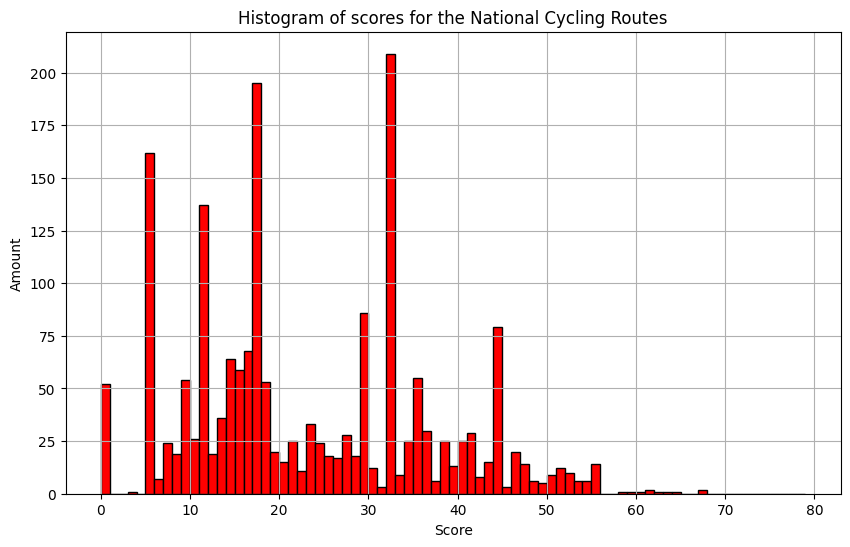

In [30]:
JSON_folder_3 = "../data/json_data/ncn_japan/"
with open(JSON_folder_3 + 'ways.json') as f:
    data = json.load(f)

df_ncn_ways = pd.json_normalize(data)

df_selected_ncn_ways = df_selected_ways[df_selected_ways['id'].isin(df_ncn_ways['id'])]

# Define the bin edges
min_score = int(df_selected_ncn_ways['score'].min())
max_score = int(df_selected_ncn_ways['score'].max())
bins = range(min_score, max_score + 1, 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_selected_ncn_ways['score'], bins=bins, edgecolor='black', alpha=1, label='National Cycling Routes', color='red')
plt.title('Histogram of scores for the National Cycling Routes')
plt.xlabel('Score')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

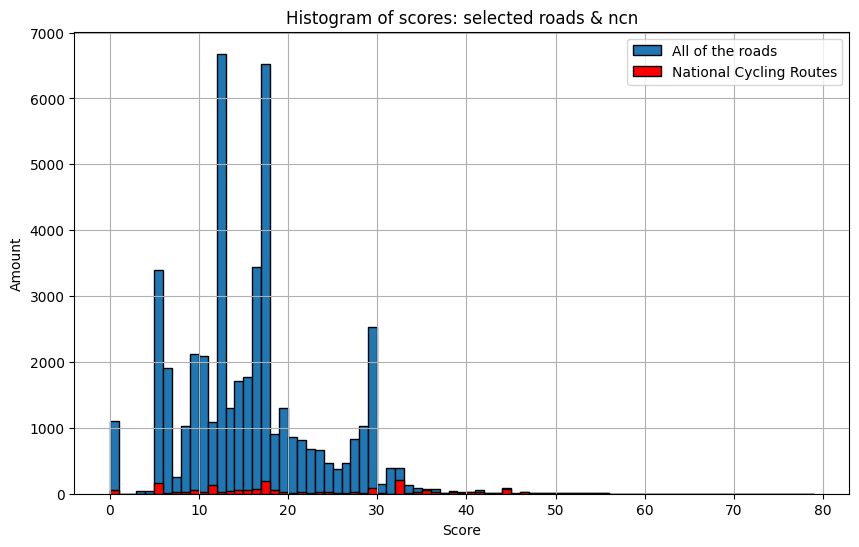

In [31]:
# Define the bin edges
min_score = int(df_selected_ncn_ways['score'].min())
max_score = int(df_selected_ncn_ways['score'].max())
bins = range(min_score, max_score + 1, 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_selected_ways['score'], bins=bins, edgecolor='black', label='All of the roads')
plt.hist(df_selected_ncn_ways['score'], bins=bins, edgecolor='black', alpha=1, label='National Cycling Routes', color='red')
plt.title('Histogram of scores: selected roads & ncn')
plt.xlabel('Score')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

Selected ways above 200 : 0


/tmp/ipykernel_7039/2393809516.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


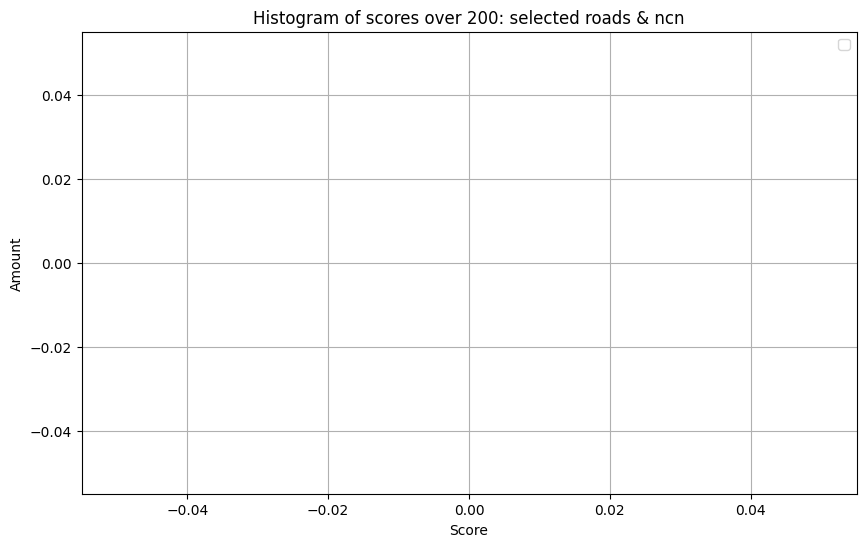

In [32]:
JSON_folder_3 = "../data/json_data/ncn_japan/"
with open(JSON_folder_3 + 'ways.json') as f:
    data = json.load(f)

df_ncn_ways = pd.json_normalize(data)

THRESHOLD = 200

print("Selected ways above",THRESHOLD,":", len(df_selected_ways['score'][df_selected_ways['score'] > THRESHOLD]))

df_selected_ncn_ways = df_selected_ways[df_selected_ways['id'].isin(df_ncn_ways['id'])]

# Define the bin edges
max_score = int(df_selected_ncn_ways['score'].max())
bins = range(THRESHOLD, max_score + 1, 1)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_selected_ways['score'][df_selected_ways['score'] > THRESHOLD], bins=bins, edgecolor='black', label='All of the roads')
plt.hist(df_selected_ncn_ways['score'][df_selected_ncn_ways['score'] > THRESHOLD], bins=bins, edgecolor='black', alpha=1, label='National Cycling Routes', color='red')
plt.title('Histogram of scores over 200: selected roads & ncn')
plt.xlabel('Score')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_7039/2354338275.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


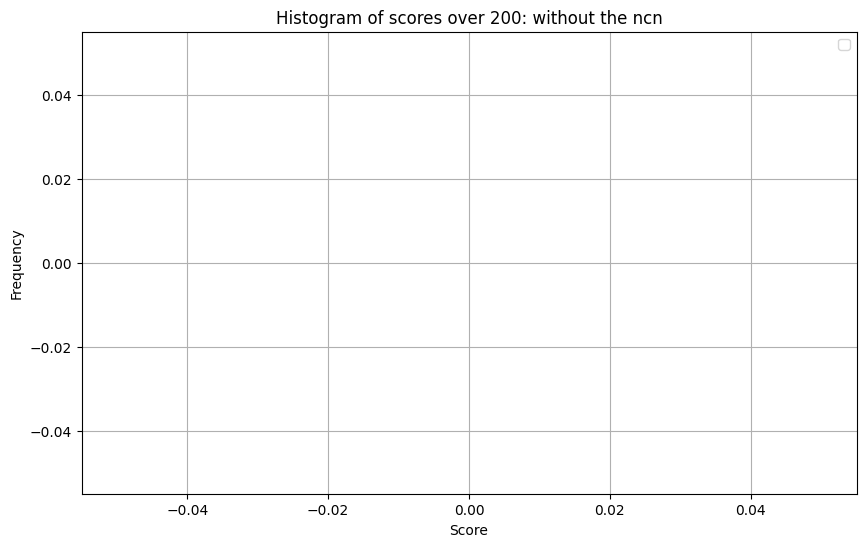

In [33]:
df_without_ncn_ways = df_selected_ways[~df_selected_ways['id'].isin(df_ncn_ways['id'])]

THRESHOLD = 200

# Define the bin edges
max_score = int(df_without_ncn_ways['score'].max())
bins = range(THRESHOLD, max_score + 1, 1)

plt.figure(figsize=(10, 6))
plt.hist(df_without_ncn_ways['score'][df_without_ncn_ways['score'] > THRESHOLD], bins=bins, edgecolor='black', color='green')
plt.title('Histogram of scores over 200: without the ncn')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True)
plt.show()